In [1]:
import data_analysis.data as data

#import data frame 
october_data = data.load_data('10.csv')

#total number of trips:
print(len(october_data))

print(october_data.dtypes)
october_data.head()

19379
started_at                   datetime64[ns, UTC]
ended_at                     datetime64[ns, UTC]
duration                                   int64
start_station_id                           int64
start_station_name                        object
start_station_description                 object
start_station_latitude                   float64
start_station_longitude                  float64
end_station_id                             int64
end_station_name                          object
end_station_description                   object
end_station_latitude                     float64
end_station_longitude                    float64
dtype: object


,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2020-10-01 01:50:02.035000+00:00,2020-10-01 02:19:36.385000+00:00,1774,1050,EICC,Outside Edinburgh International Conference Centre,55.946071,-3.210396,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185
1,2020-10-01 02:07:21.040000+00:00,2020-10-01 02:53:34.548000+00:00,2773,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750
2,2020-10-01 02:08:37.692000+00:00,2020-10-01 03:05:53.355000+00:00,3435,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750,1744,Morningside Road,"Corner of Morningside Park, beside M&S",55.927985,-3.209750
3,2020-10-01 04:25:54.283000+00:00,2020-10-01 04:45:12.275000+00:00,1157,256,St Andrews House,beside Jacobs ladder,55.953164,-3.181682,1025,Dundee Terrace,Corner of Dundee Street & Dundee Terrace,55.939710,-3.220589
4,2020-10-01 04:35:56.950000+00:00,2020-10-01 04:51:02.609000+00:00,905,1102,Haymarket Station,Haymarket Station,55.945569,-3.218185,262,Canonmills,near Tesco's,55.962804,-3.196284


In [2]:
import numpy as np
import datetime as dt

# average trip length
difference = october_data['ended_at'] - october_data['started_at']
print('Overall the average trip length is ', np.mean(difference).floor('T'))

# on weekends
weekend_oct = october_data[october_data['started_at'].dt.weekday > 4]
diff_weekend = weekend_oct['ended_at'] - weekend_oct['started_at']
print('On the weekends we have a trip length of ', np.mean(diff_weekend).floor('T'))

# during the week
week_oct = october_data[october_data['started_at'].dt.weekday < 5]
diff_week = week_oct['ended_at'] - week_oct['started_at']
print('And during the week we observe an aberage length of ',np.mean(diff_week).floor('T'))

Overall the average trip length is  0 days 00:26:00
On the weekends we have a trip length of  0 days 00:32:00
And during the week we observe an aberage length of  0 days 00:24:00


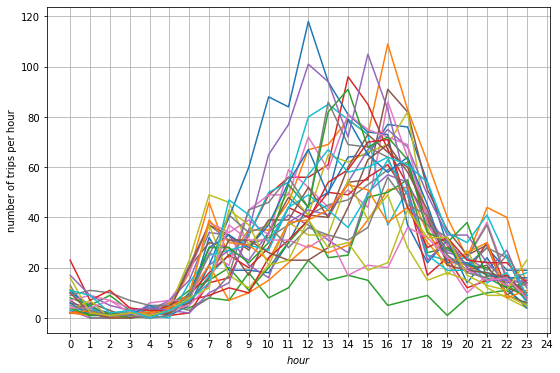

In [3]:
import matplotlib.pyplot as plt

# create a list of dataframes containing the number of trips per hour over the course of a day
trip_data = october_data.set_index('started_at')
trip_data_red = trip_data.resample('H').count()['ended_at']
trip_data_red.columns = ['number_of_trips']

DFList = []
for group in trip_data_red.groupby(trip_data_red.index.day):
    DFList.append(group[1])
#print(np.shape(DFList[1]))

# set the index to hour only in order to plot is as required
for i in range(len(DFList)):
    DFList[i].index = DFList[i].index.hour
    
#print((DFList[1]))

# plot a line for each day of the month
fig, ax = plt.subplots(figsize=(9,6))

for i in range(len(DFList)):
    ax.plot(DFList[i])
ax.set_xlabel(r'$hour$')
ax.set_ylabel('number of trips per hour')
ax.set_xticks(range(25))
plt.grid()   
plt.show()







In [2]:
import pandas as pd
import data_analysis.data as data
import datetime

october_dict = data.hourly_data_by_station(data.load_data('10.csv'))
october_dict['Abbeyhill']

,hour,mean_demand_per_hour,mean_arrivals_per_hour
0,0,0.068966,0.068966
1,1,0.103448,0.068966
2,2,0.137931,0.000000
3,3,0.000000,0.103448
4,4,0.200000,0.068966
5,5,0.166667,0.034483
6,6,0.333333,0.137931
7,7,0.466667,0.103448
8,8,0.633333,0.275862
9,9,0.466667,0.800000


In [49]:
import pandas as pd

# For the whole month:

# create a dataframe containing the number of arrivals at the respective stations
data_arrivals = october_data.groupby('end_station_name', as_index=False).count()[['end_station_name','started_at']]
data_arrivals.columns = ['station_name', 'number_of_arrivals']
data_arrivals

# create a dataframe containing the number of departures from the respective stations
data_departures = october_data.groupby('start_station_name', as_index=False).count()[['start_station_name','started_at']]
data_departures.columns = ['station_name', 'number_of_departures']
data_departures

# merge the two dataframes
arr_dep = pd.merge(data_arrivals, data_departures, how ='outer', on ='station_name')  
arr_dep['difference'] = ''
# add row containing the net demand (i.e the difference)
for i in range(len(arr_dep)):
    arr_dep.iloc[i, 3] = arr_dep.iloc[i, 1] - arr_dep.iloc[i, 2]

(arr_dep.sort_values(by=['difference']))

,station_name,number_of_arrivals,number_of_departures,difference
68,Meadow Place,467,632,-165
7,Bruntsfield Links,293,454,-161
5,Bristo Square,233,391,-158
13,Charlotte Square,185,313,-128
108,West Crosscauseway,208,336,-128
...,...,...,...,...
96,Stockbridge,316,199,117
62,Leith Walk,586,451,135
102,Victoria Quay,473,335,138
84,Portobello - Kings Road,583,431,152


# Potentially interesting data

 
 -new dataframe station-arrivals-departures-difference
        > month
        >day
        >different hour intervals
        
     --> what's a good scope for model? When will we start running out of bikes?
     
 -calculate distances beween stations  (station - station - distance)
 -visualise stations and the routes driven on a map
 
 -plot the differences of arrivals and departures over time (e.g. per day) to identify differences over time in demand

<IPython.core.display.Javascript object>


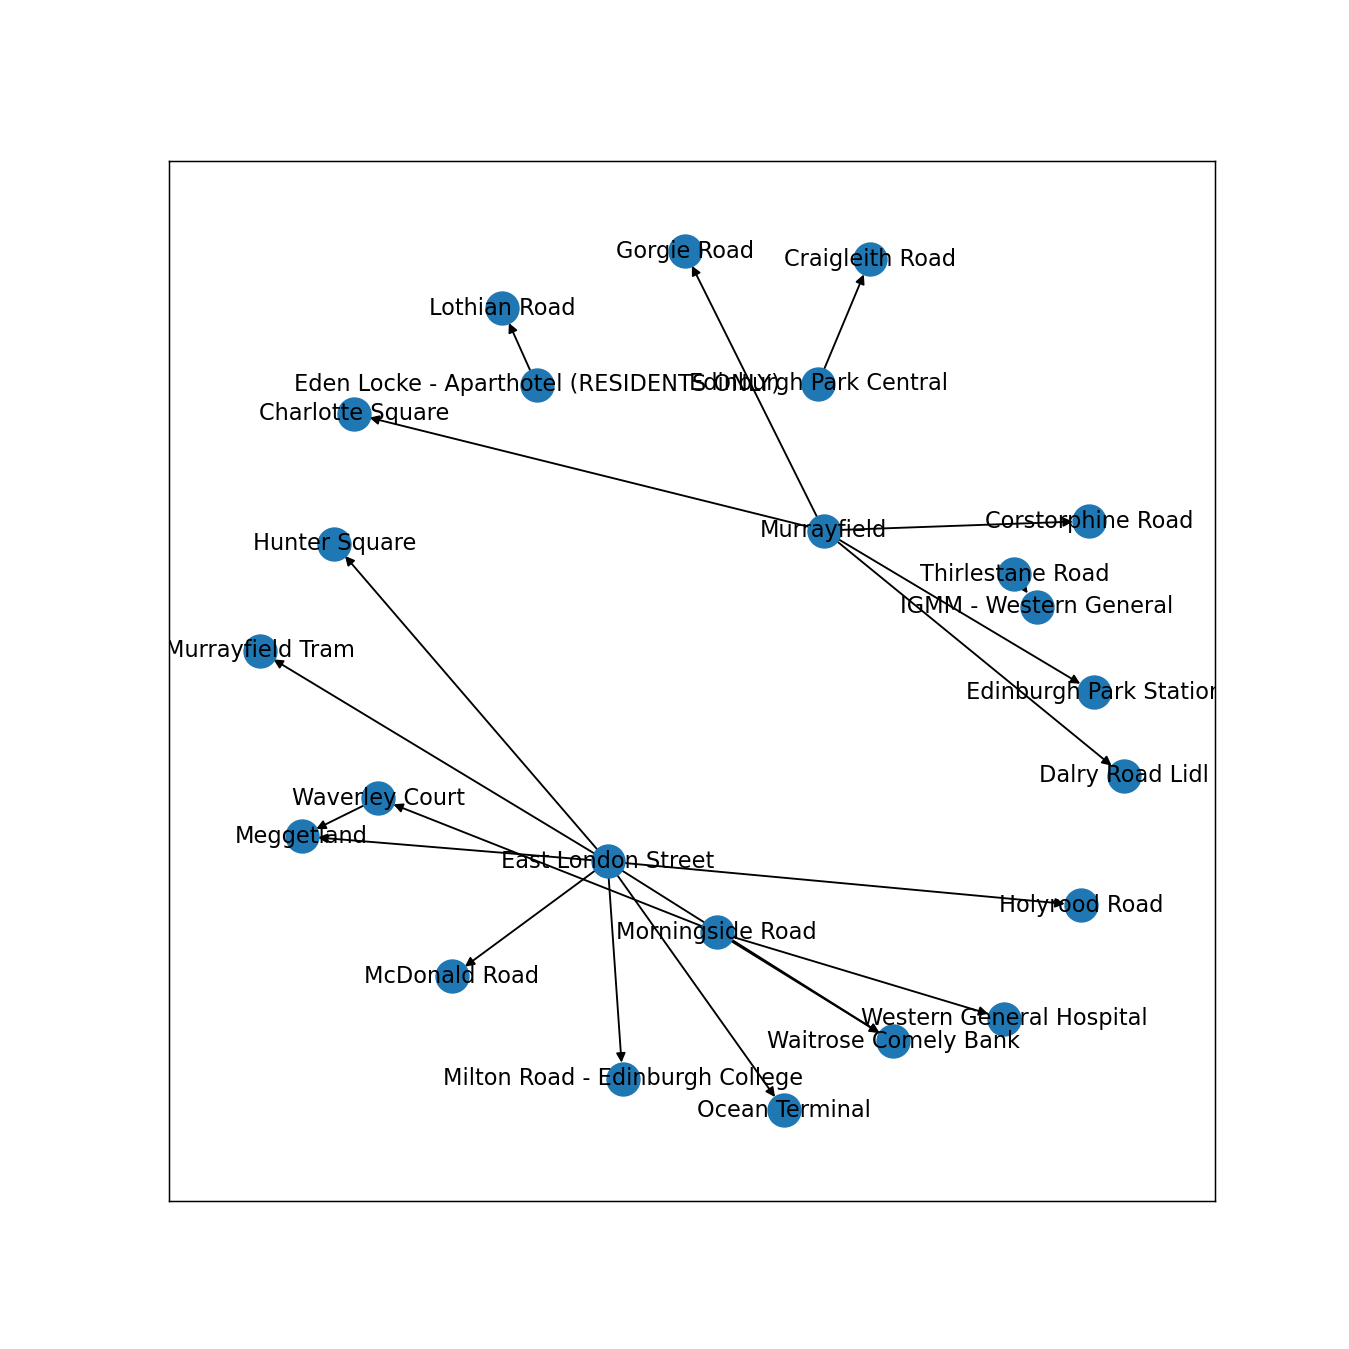

In [8]:
import pandas as pd
%matplotlib notebook
import networkx as nx
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap as Basemap


# create dataframe that contains the number of trips per month on each arc
num_trips = october_data.groupby(['start_station_name','end_station_name']).agg({'started_at': ['count']}).reset_index()
num_trips.columns = ['start_station_name', 'end_station_name', 'number_of_trips']
num_trips.head()

#plot the network
graph = nx.from_pandas_edgelist(num_trips.sort_values(by=['number_of_trips']).head(20), source = 'start_station_name', target = 'end_station_name', edge_attr = True, create_using = nx.DiGraph())
plt.figure(figsize = (10,10))
nx.draw_networkx(graph)
plt.show()

In [34]:
# compute distance between stations
import pandas as pd
import data_analysis.data as data

# get names of all existing stations
unique_stations = october_data.start_station_name.unique()

#create empty dataframe
df_loc = pd.DataFrame(columns = ['station_name', 'latitude', 'longitude'])

# extract coordinates for each station
for station in unique_stations:
    lat = (october_data[october_data['start_station_name'] == station].iloc[0,6])
    long = (october_data[october_data['start_station_name'] == station].iloc[0,7])
    new_row = {'station_name': station, 'latitude': lat, 'longitude': long}
    #append row to the dataframe
    df_loc = df_loc.append(new_row, ignore_index=True)

    
df_dist = pd.DataFrame(columns = ['station_1', 'station_2', 'distance'])
# calculate distances
for station_1 in df_loc['station_name']:
    for station_2 in df_loc['station_name']:
        lat_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,1]
        long_1 = df_loc[df_loc['station_name'] == station_1].iloc[0,2]
        
        lat_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,1]
        long_2 = df_loc[df_loc['station_name'] == station_2].iloc[0,2]
        
        dist = data.compute_distance(lat_1, long_1, lat_2, long_2)
        
        new_row = {'station_1': station_1, 'station_2': station_2, 'distance': dist}
        #append row to the dataframe
        df_dist = df_dist.append(new_row, ignore_index=True)

df_dist


,station_1,station_2,distance
0,EICC,EICC,0.000000
1,EICC,Morningside Road,115.306371
2,EICC,St Andrews House,157.744383
3,EICC,Haymarket Station,41.010193
4,EICC,Abbeyhill,209.422398
...,...,...,...
12316,Eden Locke - Aparthotel (RESIDENTS ONLY),Tesco Ferrymuir,1060.905562
12317,Eden Locke - Aparthotel (RESIDENTS ONLY),Picady Place,105.603109
12318,Eden Locke - Aparthotel (RESIDENTS ONLY),Picardy Place,105.603109
12319,Eden Locke - Aparthotel (RESIDENTS ONLY),Scotstoun House,1019.601429
